# KANSR Class-Based API Example

This notebook demonstrates how to use the KANSR class from the LLMSR package to perform symbolic regression using Kolmogorov-Arnold Networks (KANs).

In [1]:
%cd ..

/Users/kit/Documents/Phys_Working/LLM_SR


/Users/kit/Documents/Phys_Working/LLM_SR/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import openai
import os
from dotenv import load_dotenv
from LLMSR.kansr import KANSR
import LLMSR
# Load environment variables
load_dotenv()

# Import the KANSR class
from LLMSR.kansr import KANSR

## Set up the client for API calls

In [3]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY") if os.getenv("OPENROUTER_API_KEY") else "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",
)
LLMSR.llm.check_key_limit(client)

2025-03-13 19:36:36,033 - LLMSR.llm - INFO - API key check successful. Remaining limit: None


## Define a function to model

Let's use a simple function with a mix of trigonometric and polynomial terms.

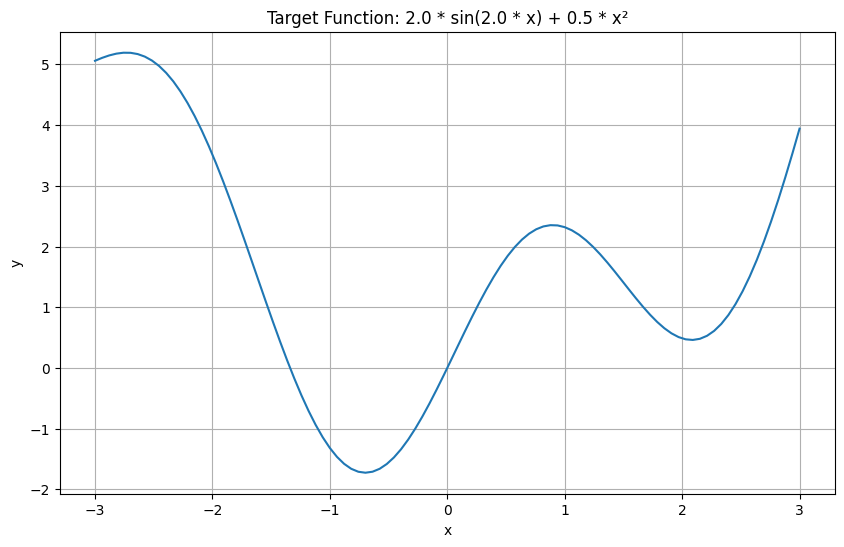

In [4]:
# Define the target function
def target_function(x):
    if isinstance(x, torch.Tensor):
        return 2.0 * torch.sin(2.0 * x) + 0.5 * x**2
    else:
        return 2.0 * np.sin(2.0 * x) + 0.5 * x**2

# Plot the function
x = np.linspace(-3, 3, 100)
y = target_function(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title("Target Function: 2.0 * sin(2.0 * x) + 0.5 * x²")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Method 1: Step-by-Step Approach

The KANSR class provides flexibility by letting you run each step individually.

In [5]:
# Initialize the KANSR instance
# The architecture [1,4,1] means: 1 input node, 4 hidden nodes, 1 output node
kansr = KANSR(
    client=client,      # API client for LLM calls
    width=[1, 4, 1],    # Network architecture
    grid=5,             # Grid size for KAN
    k=3,                # Number of basis functions
    seed=42             # Random seed for reproducibility
)

checkpoint directory created: ./model
saving model version 0.0


In [6]:
# Step 1: Create a dataset for training
dataset = kansr.create_dataset(
    f=target_function,    # The function to approximate
    ranges=(-3, 3),       # Input range
    n_var=1,              # Number of input variables
    train_num=5000,       # Number of training points
    test_num=1000         # Number of test points
)

2025-03-13 19:36:36,134 - LLMSR.kansr - INFO - Training KAN model with LBFGS optimiser for 50 steps
| train_loss: 2.10e-03 | test_loss: 2.04e-03 | reg: 1.22e+01 | : 100%|█| 50/50 [00:21<00:00,  2.32it


saving model version 0.1
Unpruned model. Pruning? True


2025-03-13 19:36:58,061 - LLMSR.kansr - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-13 19:36:58,071 - LLMSR.kansr - INFO - Pruned model:
2025-03-13 19:36:58,198 - LLMSR.kansr - INFO - Final train loss: 0.002097120275720954


saving model version 0.2


0.002097120275720954

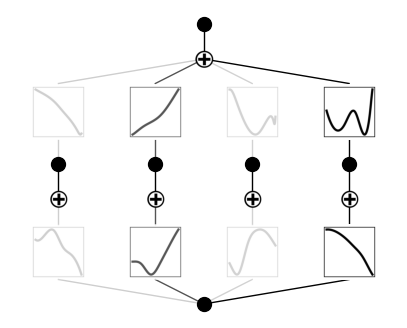

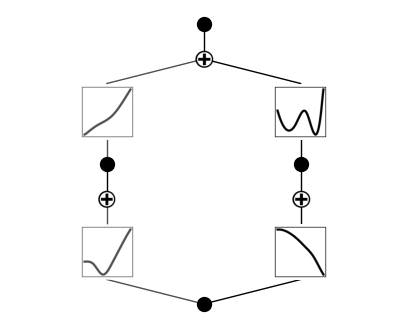

In [7]:
# Step 2: Train the KAN model
kansr.train_kan(
    dataset=dataset,   # The dataset to train on
    opt="LBFGS",       # Optimization algorithm
    steps=50,          # Number of optimization steps
    prune=True,        # Whether to prune the model after training
    node_th=0.2,       # Node threshold for pruning
    edge_th=0.2        # Edge threshold for pruning
)

2025-03-13 19:36:58,713 - LLMSR.llm - INFO - API key usage check successful. Current usage: 56.609975546
2025-03-13 19:36:58,714 - LLMSR.kansr - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-13 19:36:58,714 - LLMSR.kansr - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-13 19:36:58,835 - LLMSR.llm - INFO - API key usage check successful. Current usage: 56.609975546
2025-03-13 19:36:58,835 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-13 19:36:58,837 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,0)


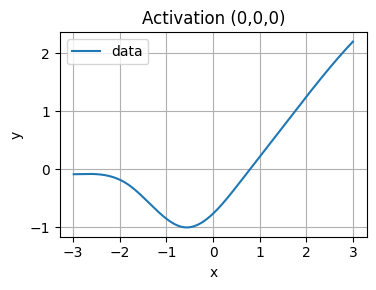

2025-03-13 19:36:58,918 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-13 19:36:59,185 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -2.1789491176605225, for constant: [0.11659531]
2025-03-13 19:36:59,186 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 19:37:01,407 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 19:37:01,407 - LLMSR.llmSR - INFO - Initial population best: score=-0.09412278980016708, params=[ 0.22088813  0.38752581 -0.55096726], ansatz: params[0] * x**2 + params[1] * x + params[2]...


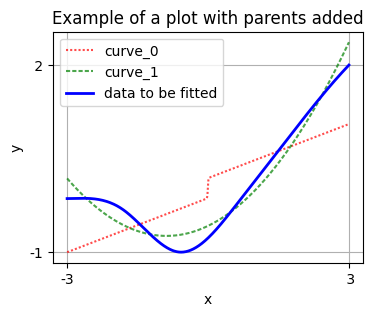

2025-03-13 19:37:01,449 - LLMSR.llmSR - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:04,319 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.08687636256217957, params=[ 1.05388     0.43874009  0.22143592 -0.55305069], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3]...
2025-03-13 19:37:04,320 - LLMSR.llmSR - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:06,898 - LLMSR.llmSR - INFO - Generation 2 best: score=-0.015083540230989456, params=[ 0.48882644  1.28582628  0.05803821 -0.84346546  1.14667118], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * np.cos(params[4] * x)...
2025-03-13 19:37:06,899 - LLMSR.llmSR - INFO - Generation 3/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:11,309 - LLMSR.llmSR - INFO - Generation 3 best: score=-0.016604989767074585, params=[ 1.04666541  0.44302322  0.02730793 -0.75354473  1.0946434 ], ansatz: params[


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 40 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 40 succeeded, 0 failed (100.00% success)
  Function Conversion: 40 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,0): params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * np.cos(params[4] * x), with score -0.015083540230989456 and parameters [ 0.489  1.286  0.058 -0.843  1.147]


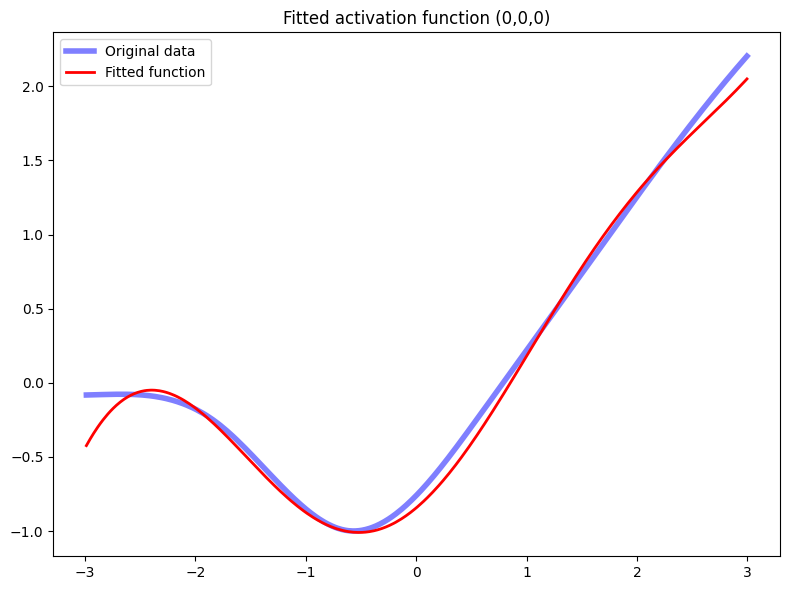

2025-03-13 19:37:11,481 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,1)


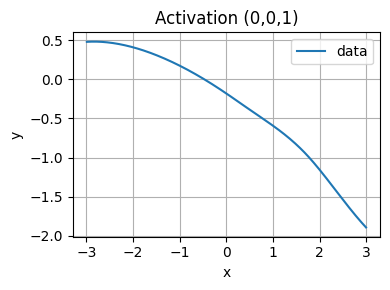

2025-03-13 19:37:11,547 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-13 19:37:11,549 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.623329758644104, for constant: [-0.35051981]
2025-03-13 19:37:11,549 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 19:37:15,107 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 19:37:15,108 - LLMSR.llmSR - INFO - Initial population best: score=-0.08600911498069763, params=[-0.32752628 -0.41150303  0.03968479], ansatz: params[0] + params[1] * x + params[2] * np.sin(x)...


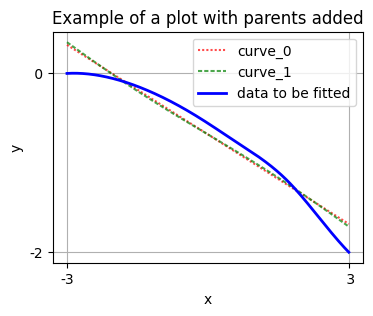

2025-03-13 19:37:15,168 - LLMSR.llmSR - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:18,300 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.0016737431287765503, params=[-1.2099104   0.30175187  1.04974862], ansatz: params[0] * np.exp(params[1] * x) + params[2]...
2025-03-13 19:37:18,302 - LLMSR.llmSR - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:21,538 - LLMSR.llmSR - INFO - Generation 2 best: score=-0.0004748005303554237, params=[-2.00400056  0.37646584  0.89411096 -0.1399699   1.2591217 ], ansatz: params[0] * np.tanh(params[1] * x + params[2]) + params[3] * x**2 + params[4]...
2025-03-13 19:37:21,540 - LLMSR.llmSR - INFO - Exit condition met after generation 2: -0.0004748005303554237>-0.001
2025-03-13 19:37:21,541 - LLMSR.llmSR - INFO - Validation issues detected during genetic algorithm run, see summary.
2025-03-13 19:37:21,541 - LLMSR.llmSR - INFO - Successfully found expression for connection (0,


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  No errors

Validation issues:
  - nan values: 2

Fitting warnings:
  - covariance estimation: 2
  - invalid log: 11
Approximation for (0,0,1): params[0] * np.tanh(params[1] * x + params[2]) + params[3] * x**2 + params[4], with score -0.0004748005303554237 and parameters [-2.004  0.376  0.894 -0.14   1.259]


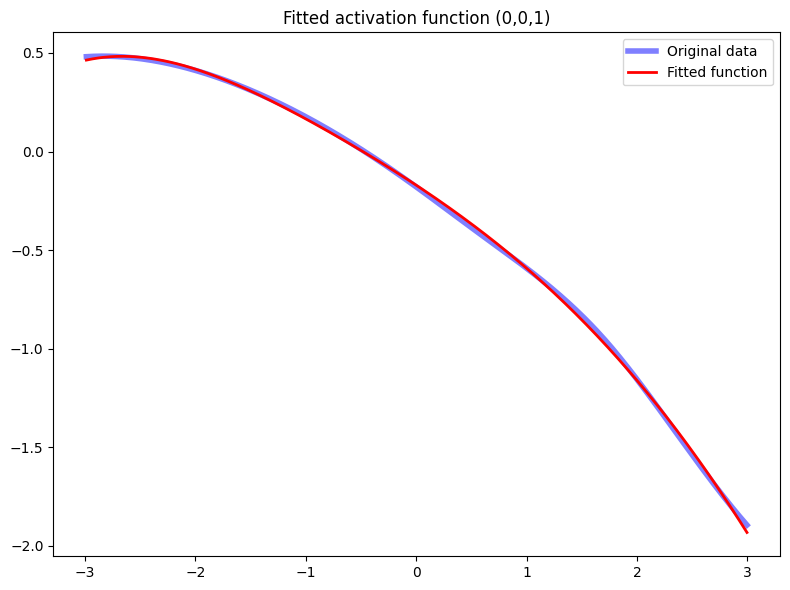

2025-03-13 19:37:21,622 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,0,0)


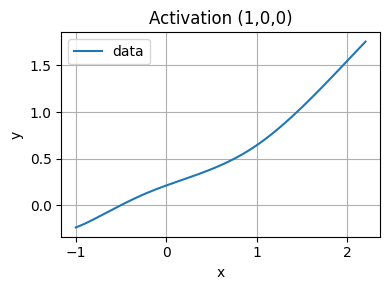

2025-03-13 19:37:21,680 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-13 19:37:21,681 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -3.7745518684387207, for constant: [0.31533158]
2025-03-13 19:37:21,681 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 19:37:25,300 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 19:37:25,301 - LLMSR.llmSR - INFO - Found 1 non-finite scores, setting all to -101.20418047904968. Example ansatz: params[0] * np.log(x + params[1]) + params[2]
2025-03-13 19:37:25,301 - LLMSR.llmSR - INFO - Initial population best: score=-0.003057815134525299, params=[0.07192762 0.38473699 0.20714361], ansatz: params[0] * np.power(x, 3) + params[1] * x + params[2]...


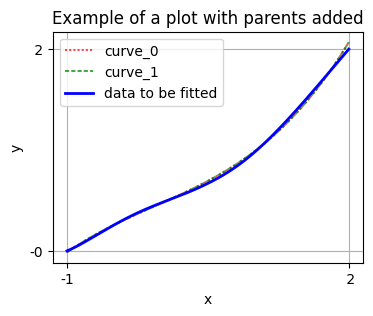

2025-03-13 19:37:25,343 - LLMSR.llmSR - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:29,008 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.0013780980370938778, params=[-0.28615493  1.36116317 -0.00355613  0.73724448  0.20382566], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...
2025-03-13 19:37:29,009 - LLMSR.llmSR - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:33,738 - LLMSR.fit - INFO - All methods failed for this fit <function <lambda> at 0x162f295a0> Optimal parameters not found: Number of calls to function has reached maxfev = 5000.
2025-03-13 19:37:36,720 - LLMSR.llmSR - INFO - Generation 2 best: score=-0.0014858932700008154, params=[-2.01130556  0.57157187 -0.00245585  1.49679299  0.20364192], ansatz: params[0] * np.tanh(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...
2025-03-13 19:37:36,720 - LLMSR.llmSR - INFO - Generation 3/3: Gener


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 3
  Success rate: 93.02%

Breakdown by processing stage:
  Api Call: 43 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 42 succeeded, 1 failed (97.67% success)
  Function Conversion: 42 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 2 failed (95.24% success)

Error types:
  Extraction Errors:
    - llm refusal: 1
  Fitting Errors:
    - numerical error: 2

Validation issues:
  - nan values: 1

Fitting warnings:
  - invalid sqrt: 4
  - covariance estimation: 1
  - invalid log: 5
Approximation for (1,0,0): params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4], with score -0.0013780980370938778 and parameters [-0.286  1.361 -0.004  0.737  0.204]


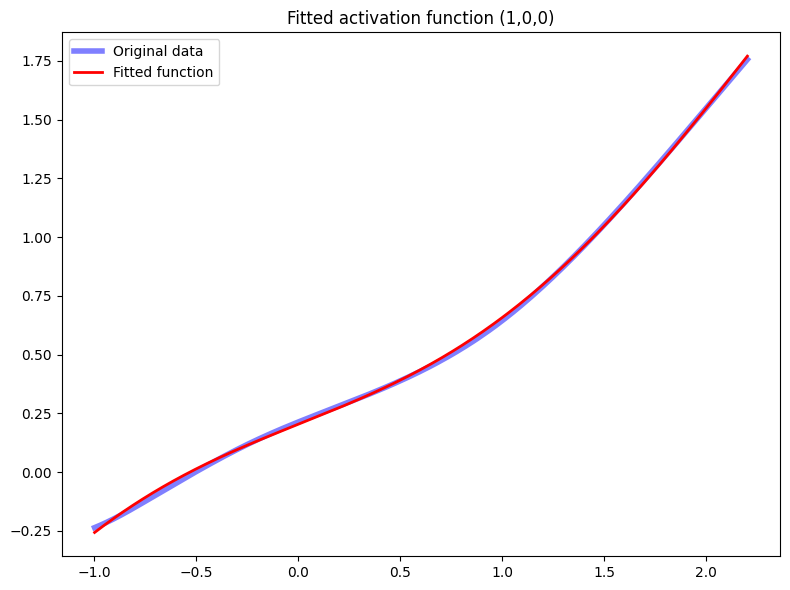

2025-03-13 19:37:44,733 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,1,0)


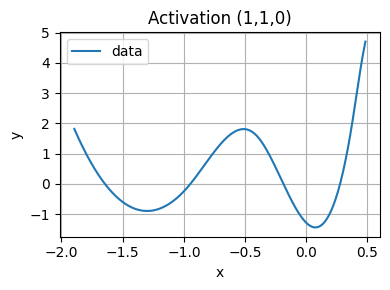

2025-03-13 19:37:44,802 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-13 19:37:44,803 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -2.3975510597229004, for constant: [0.89168379]
2025-03-13 19:37:44,804 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 19:37:48,186 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 19:37:48,209 - LLMSR.llmSR - INFO - Initial population best: score=-0.20406614243984222, params=[10.93615689 -2.23747692 16.42389131 23.41835491 -0.97492642], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...


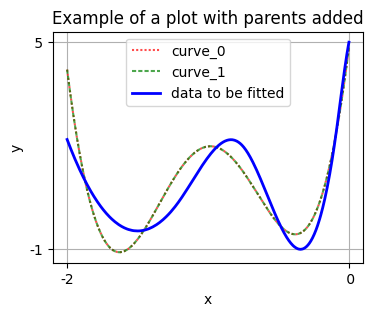

2025-03-13 19:37:48,495 - LLMSR.llmSR - INFO - Generation 1/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:52,275 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.20406614243984222, params=[ 1.09362869e+01 -2.23747451e+00 -1.13593488e+01 -5.44271186e-03
  1.64238926e+01  2.34186023e+01  1.03843992e+01], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**2 + params[5]...
2025-03-13 19:37:52,276 - LLMSR.llmSR - INFO - Generation 2/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:37:57,906 - LLMSR.llmSR - INFO - Generation 2 best: score=-0.0035876522306352854, params=[ 2.23676431 -4.83231029 -4.23774473 -3.51543265 -2.63755664 -0.63913066
  6.9494499   2.88275178], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**3 + params[5]...
2025-03-13 19:37:57,907 - LLMSR.llmSR - INFO - Generation 3/3: Generating 10 new individuals. Elitism? False
2025-03-13 19:38:03,538 - LLM


API Call Statistics:
  Successful calls (end-to-end): 40
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 40 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 40 succeeded, 0 failed (100.00% success)
  Function Conversion: 40 succeeded, 0 failed (100.00% success)
  Curve Fitting: 40 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,1,0): params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x) + params[4] * x**3 + params[5] * x**2 + params[6] * np.exp(params[7] * x), with score -0.0020830936264246702 and parameters [ 1.449 -5.242 -2.504  4.105 -1.475 -2.001  1.183  3.079]


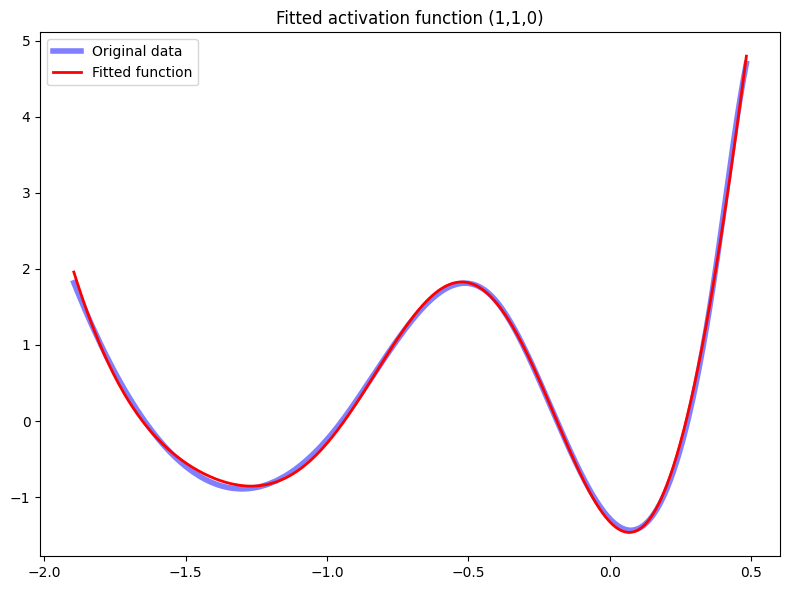

2025-03-13 19:38:03,638 - LLMSR.llmSR - INFO - KAN conversion complete: 4 total connections
2025-03-13 19:38:03,638 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 4 processed
2025-03-13 19:38:03,870 - LLMSR.llm - INFO - API key usage check successful. Current usage: 56.664735546
2025-03-13 19:38:03,870 - LLMSR.llmSR - INFO - API key usage whilst this kan_to_symbolic was running: $0.05
2025-03-13 19:38:03,871 - LLMSR.kansr - INFO - Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x) + params[2] * x**3 + params[3] * np.cos(params[4] * x), has parameters [ 0.5  1.3  0.1 -0.8  1.1]
2025-03-13 19:38:03,871 - LLMSR.kansr - INFO - Approximation for (0, 0, 1): params[0] * np.tanh(params[1] * x + params[2]) + params[3] * x**2 + params[4], has parameters [-2.   0.4  0.9 -0.1  1.3]
2025-03-13 19:38:03,872 - LLMSR.kansr - INFO - Approximation for (1, 0, 0): params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4], has parameters [-0.3  1.4 -0.  

In [ ]:
# Step 3: Convert the KAN model to symbolic expressions
best_expressions, best_chi_squareds, results_dicts, results_all_dicts = kansr.get_symbolic(
    client=client,              # Client for LLM API calls
    population=10,              # Population size for genetic algorithm
    generations=4,              # Number of generations for genetic algorithm
    temperature=0.1,            # Temperature parameter for genetic algorithm
    gpt_model="openai/gpt-4o",  # GPT model to use
    verbose=1,                  # Verbosity level
    use_async=True,             # Whether to use async execution
    plot_fit=True,               # Whether to plot fitting results
    plot_parents=True,
    demonstrate_parent_plotting=True,
    )


In [14]:
# Print the best expression and its chi-squared value
print(f"Best expression: {best_expressions[0]}")
print(f"Chi-squared: {best_chi_squareds[0]}")

Best expression: -0.250894690053285*x0**3 + 0.694392454832144*np.exp(0.917777728949437*x0) + 1.69339585297329*np.sin(2.17975417769256*x0) + 0.0630158579139874*np.cos(5.46694065789684*x0) - 0.47397857925858
Chi-squared: 0.0395759679377079


2025-03-13 19:22:59,761 - LLMSR.kansr - INFO - Using internal dataset for plotting
2025-03-13 19:22:59,762 - LLMSR.kansr - INFO - Using provided ranges: (-3, 3)
2025-03-13 19:22:59,762 - LLMSR.kansr - INFO - Using self.f function for ground truth
2025-03-13 19:22:59,770 - LLMSR.kansr - INFO - Plotting raw expression
2025-03-13 19:22:59,771 - LLMSR.kansr - INFO - Plotting simplified and refitted/pruned raw expression
2025-03-13 19:22:59,772 - LLMSR.kansr - INFO - Plotting simplified by LLM expression
2025-03-13 19:22:59,772 - LLMSR.kansr - INFO - Argument x of learned function are arraylike, NOT x0, x1, etc.
2025-03-13 19:22:59,773 - LLMSR.kansr - WARNING - Error in processing symbolic KAN directly to python function: KANSR._find_optimised_for_full_python_kan_function() got multiple values for argument 'try_jax'


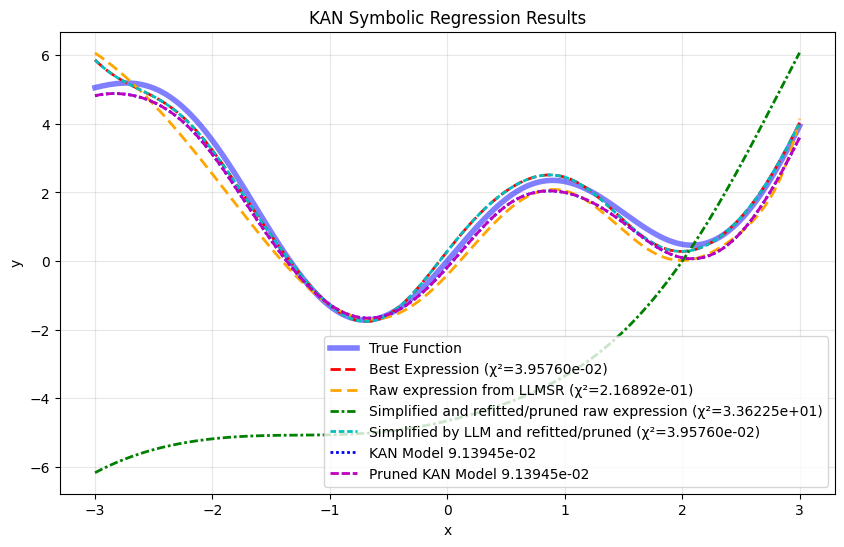

In [10]:
# Plot the results
kansr.plot_results(
    ranges=(-3, 3),           # Input range for plotting
    result_dict=kansr.results_all_dicts[0],  # Results dictionary from get_symbolic
    title="KAN Symbolic Regression Results"  # Plot title
)
plt.show()

## Method 2: All-in-One Pipeline

For convenience, you can run the entire pipeline in one call.

In [11]:
# Initialize a new KANSR instance
kansr2 = KANSR(
    client=client,
    width=[1, 5, 1],  # Using a slightly different architecture
    grid=6,
    k=3,
    seed=17
)

checkpoint directory created: ./model
saving model version 0.0


In [12]:
# Run the complete pipeline
results = kansr2.run_complete_pipeline(
    client=client,
    f=target_function,
    ranges=(-3, 3),
    train_steps=500,
    generations=4,
    gpt_model="openai/gpt-4o",
    node_th=0.2,
    edge_th=0.2,
    optimiser="LBFGS",
    population=10,
    temperature=0.1,
    verbose=1,
    use_async=True,
    plot_fit=True
)

2025-03-13 19:22:59,884 - LLMSR.kansr - ERROR - Error in pipeline: Target function f must not use numpy, use torch instead, returning partial results: ['trained_model']


In [13]:
# Print the best expression from the pipeline
print(f"Best expression from pipeline: {results['best_expressions'][0]}")
print(f"Chi-squared: {results['best_n_chi_squareds'][0]}")

KeyError: 'best_expressions'

## Method 3: Using the standalone function

You can also use the standalone function `run_complete_pipeline` from the kansr module. Note you can also decide to use a different LLM for simplification.

2025-03-13 05:39:56,581 - LLMSR.kansr - INFO - Training KAN model with LBFGS optimizer for 50 steps


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.26e-03 | test_loss: 1.27e-03 | reg: 1.48e+01 | : 100%|█| 50/50 [00:22<00:00,  2.25it


saving model version 0.1
Unpruned model. Pruning? True


2025-03-13 05:40:19,124 - LLMSR.kansr - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-13 05:40:19,137 - LLMSR.kansr - INFO - Pruned model:


saving model version 0.2


2025-03-13 05:40:19,392 - LLMSR.kansr - INFO - Final train loss: 0.0012644767994061112
2025-03-13 05:40:19,392 - LLMSR.kansr - INFO - Trained model:
2025-03-13 05:40:19,643 - LLMSR.kansr - INFO - Pruned model:
2025-03-13 05:40:20,088 - LLMSR.llm - INFO - API key usage check successful. Current usage: 52.345563246
2025-03-13 05:40:20,089 - LLMSR.kansr - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-13 05:40:20,090 - LLMSR.kansr - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-13 05:40:20,223 - LLMSR.llm - INFO - API key usage check successful. Current usage: 52.345563246
2025-03-13 05:40:20,225 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-13 05:40:20,227 - LLMSR.llmSR - INFO - Processing non-symbolic ac

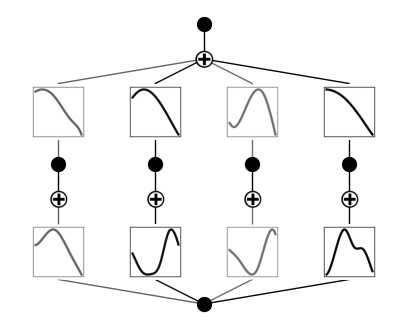

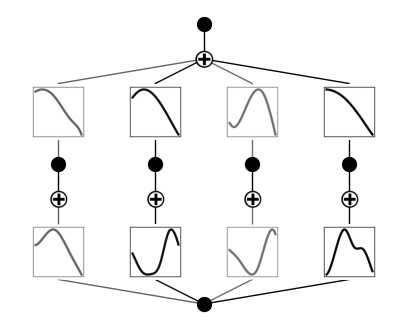

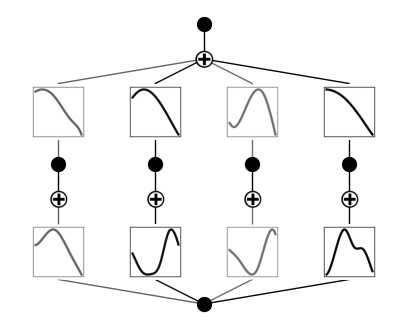

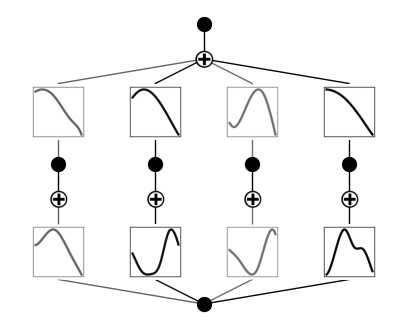

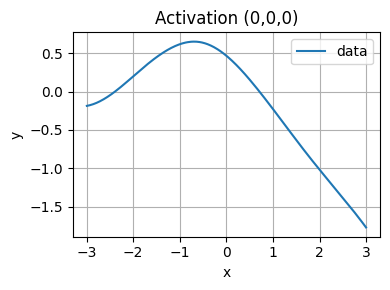

2025-03-13 05:40:20,953 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-13 05:40:20,955 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.9920780658721924, for constant: [-0.14464983]
2025-03-13 05:40:20,955 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:40:23,687 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:40:23,688 - LLMSR.llmSR - INFO - Initial population best: score=-0.010965855792164803, params=[ 1.33575382  0.62486844  2.1115234  -0.72698936], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3]...
2025-03-13 05:40:23,688 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-13 05:40:25,780 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.010965853929519653, params=[ 1.33575423  0.62486825  0.54072698 -0.72698985], ansatz: params[0] * np.cos(params[1] * x + params[2]) + params[3]...
2025-03-13 05:40:25,781 - LL


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,0): params[0] * np.cos(params[1] * x + params[2]) + params[3], with score -0.010965853929519653 and parameters [ 1.336  0.625  0.541 -0.727]


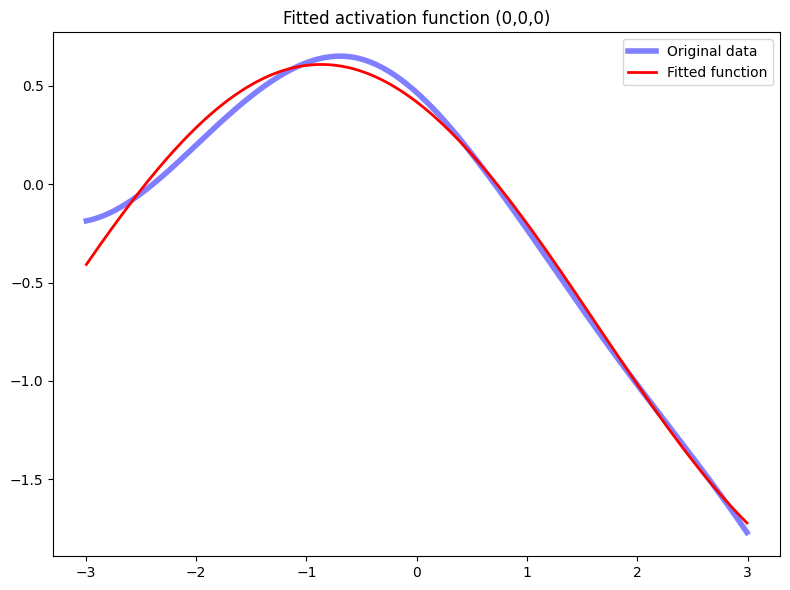

2025-03-13 05:40:28,564 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,1)


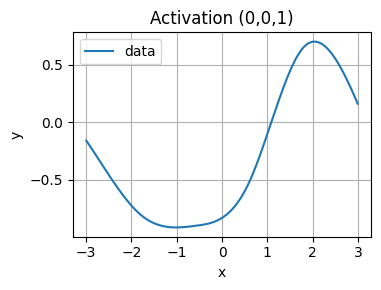

2025-03-13 05:40:28,632 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,1)
2025-03-13 05:40:28,633 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -2.0627214908599854, for constant: [-0.30288281]
2025-03-13 05:40:28,634 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:40:32,876 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:40:32,876 - LLMSR.llmSR - INFO - Initial population best: score=-0.1259375512599945, params=[ 0.62737166  0.87059583 -0.68168171  0.68403907], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x)...
2025-03-13 05:40:32,877 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-13 05:40:36,897 - LLMSR.fit - INFO - Fitting curve with JAX method BFGS, initial parameters [1. 1. 1. 1.]
2025-03-13 05:40:37,186 - LLMSR.fit - INFO - Fitting curve with initial parameters [1. 1. 1....
2025-03-13 05:40:37,234 - LLMS


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 1
  Success rate: 96.77%

Breakdown by processing stage:
  Api Call: 31 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 31 succeeded, 0 failed (100.00% success)
  Function Conversion: 31 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 1 failed (96.77% success)

Error types:
  Fitting Errors:
    - numerical error: 1

Fitting warnings:
  - other warnings: 1
Approximation for (0,0,1): params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4], with score -0.041824791580438614 and parameters [ 1.465  0.885  5.153 -0.195  0.514]


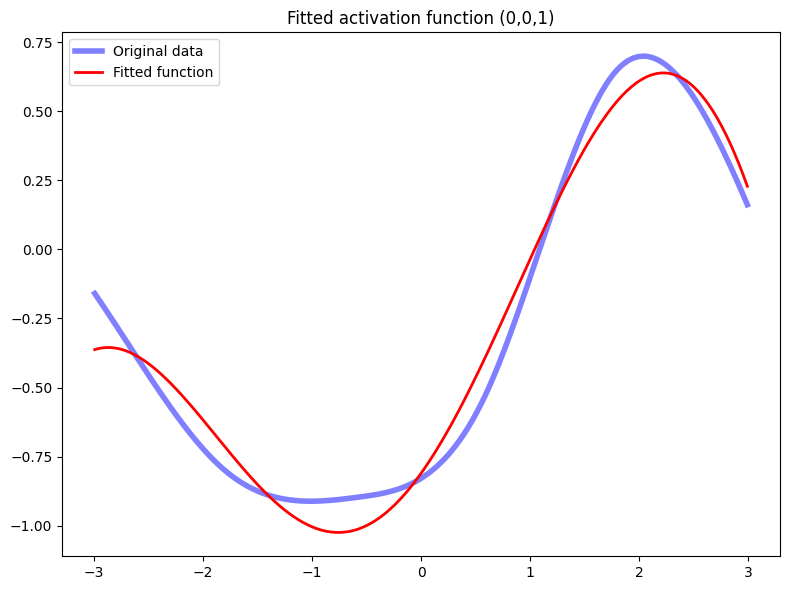

2025-03-13 05:40:43,558 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,2)


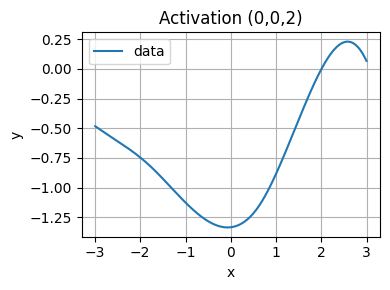

2025-03-13 05:40:43,627 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,2)
2025-03-13 05:40:43,629 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.822348952293396, for constant: [-0.70028931]
2025-03-13 05:40:43,629 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:40:46,234 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:40:46,234 - LLMSR.llmSR - INFO - Initial population best: score=-0.11071270704269409, params=[-0.8816713   0.7361169   1.97033043 -0.41082209], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3]...
2025-03-13 05:40:46,235 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-13 05:40:51,903 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.11729084700345993, params=[ 0.52881164  0.33112758 -1.20017643 -0.56591455], ansatz: params[0] * np.sin(params[1] * x) + params[2] * np.cos(params[3] * x)...
2025-03-13 05:40:51


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,2): params[0] * np.sin(params[1] * x + params[2]) + params[3], with score -0.11071270704269409 and parameters [-0.882  0.736  1.97  -0.411]


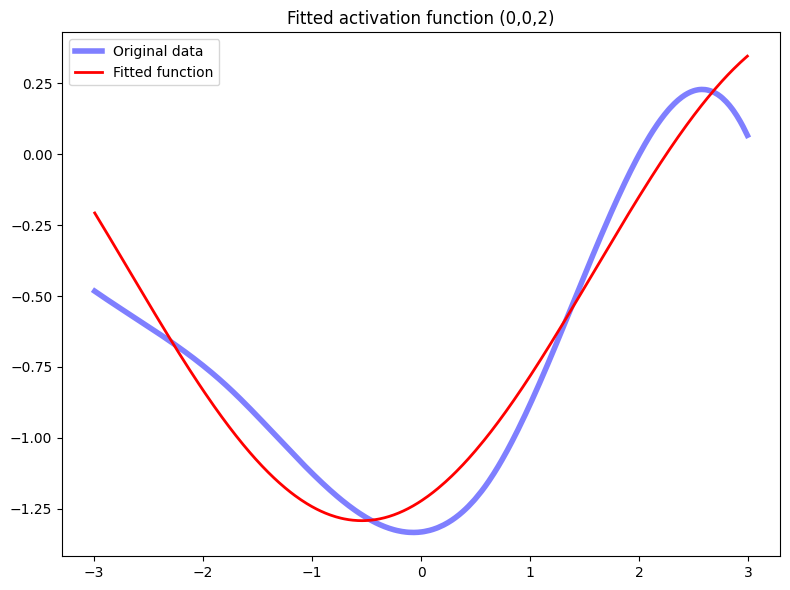

2025-03-13 05:40:55,698 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,3)


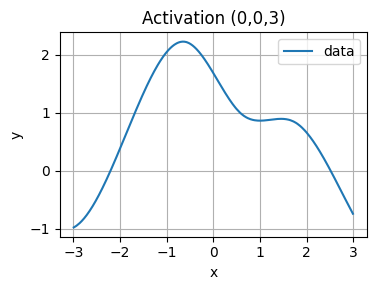

2025-03-13 05:40:55,763 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,3)
2025-03-13 05:40:55,765 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.7102301120758057, for constant: [0.80335371]
2025-03-13 05:40:55,765 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:40:58,366 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:40:58,367 - LLMSR.llmSR - INFO - Initial population best: score=-0.00906766951084137, params=[-0.54212802  1.91469267 -0.30480671 -0.09458415  1.73214206], ansatz: params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4]...
2025-03-13 05:40:58,368 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-13 05:41:01,115 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.02256910502910614, params=[-0.54611839  1.9102722   1.81102516  0.66634464 -0.09244626], ansatz: params[0] * np.sin(params[1] * x) + params[2]


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 30 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 30 succeeded, 0 failed (100.00% success)
  Function Conversion: 30 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,3): params[0] * np.sin(params[1] * x) + params[2] * x**2 + params[3] * x + params[4], with score -0.00906766951084137 and parameters [-0.542  1.915 -0.305 -0.095  1.732]


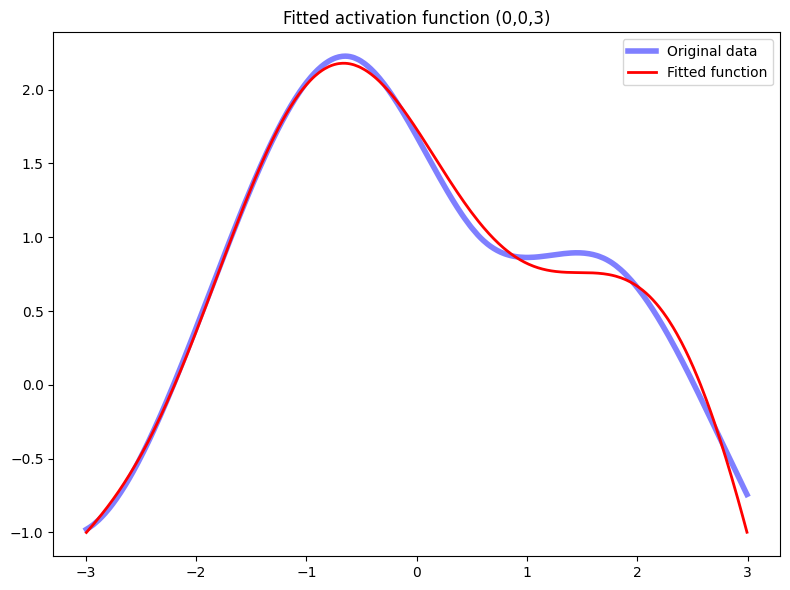

2025-03-13 05:41:03,861 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,0,0)


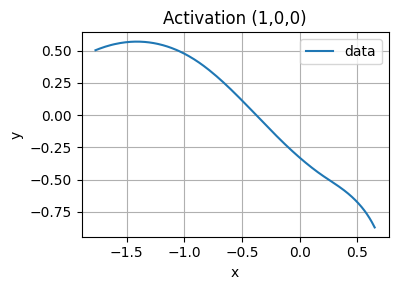

2025-03-13 05:41:04,159 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,0,0)
2025-03-13 05:41:04,161 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.8978278636932373, for constant: [-0.23331437]
2025-03-13 05:41:04,161 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:41:07,168 - LLMSR.fit - INFO - Fitting curve with JAX method BFGS, initial parameters [1. 1. 1. 1.]
2025-03-13 05:41:07,454 - LLMSR.fit - INFO - Fitting curve with initial parameters [1. 1. 1....
2025-03-13 05:41:07,502 - LLMSR.fit - INFO - Fitting curve with method lm,  with timeout: 30 seconds
2025-03-13 05:41:07,550 - LLMSR.fit - INFO - Fitting curve with method trf, trf may take some time with timeout: 30 seconds
2025-03-13 05:41:08,089 - LLMSR.fit - INFO - Fitting curve with method dogbox,  with timeout: 30 seconds
2025-03-13 05:41:08,685 - LLMSR.fit - INFO - All methods failed for this fit <function <lambda> at 0x3c16ed480> Optimal parameters n


API Call Statistics:
  Successful calls (end-to-end): 30
  Failed calls: 9
  Success rate: 76.92%

Breakdown by processing stage:
  Api Call: 39 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 38 succeeded, 1 failed (97.44% success)
  Function Conversion: 38 succeeded, 0 failed (100.00% success)
  Curve Fitting: 30 succeeded, 8 failed (78.95% success)

Error types:
  Extraction Errors:
    - no parameters: 1
  Fitting Errors:
    - numerical error: 8

Fitting warnings:
  - other warnings: 8
Approximation for (1,0,0): params[0] * np.exp(params[1] * x) + params[2] * x + params[3], with score -0.005600009113550186 and parameters [-0.006 -2.694 -0.832 -0.295]


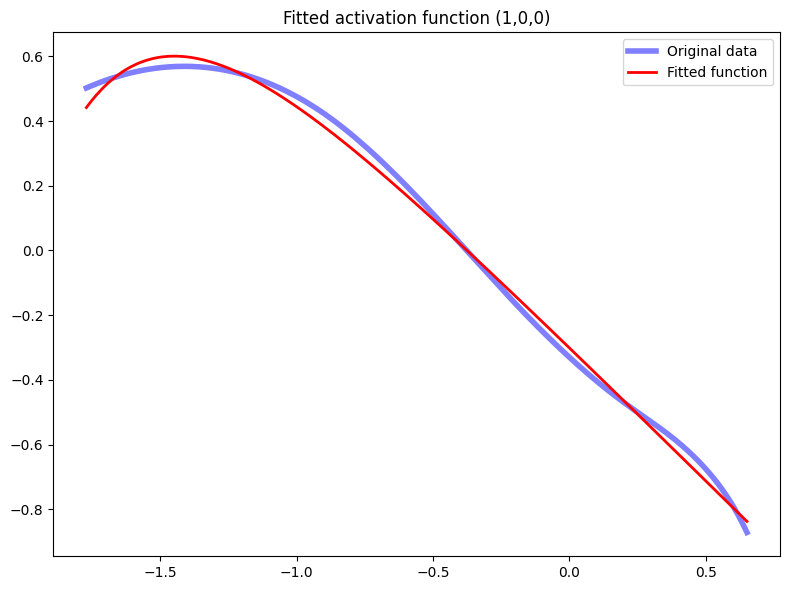

2025-03-13 05:41:46,934 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,1,0)


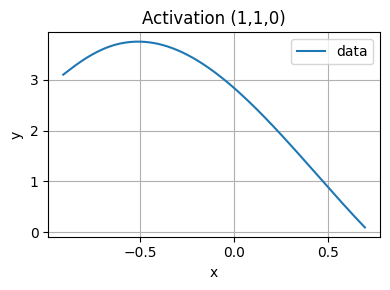

2025-03-13 05:41:46,989 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,1,0)
2025-03-13 05:41:46,991 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -7.948337078094482, for constant: [2.62483571]
2025-03-13 05:41:46,991 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:41:53,299 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:41:53,299 - LLMSR.llmSR - INFO - Initial population best: score=-0.0009105821955017745, params=[2.3457148  1.80120464 0.89244442 1.39319963], ansatz: params[0] * np.cos(params[1] * x + params[2]) + params[3]...
2025-03-13 05:41:53,300 - LLMSR.llmSR - INFO - Exit condition met after initial population
2025-03-13 05:41:53,300 - LLMSR.llmSR - INFO - Successfully found expression for connection (1,1,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,1,0): params[0] * np.cos(params[1] * x + params[2]) + params[3], with score -0.0009105821955017745 and parameters [2.346 1.801 0.892 1.393]


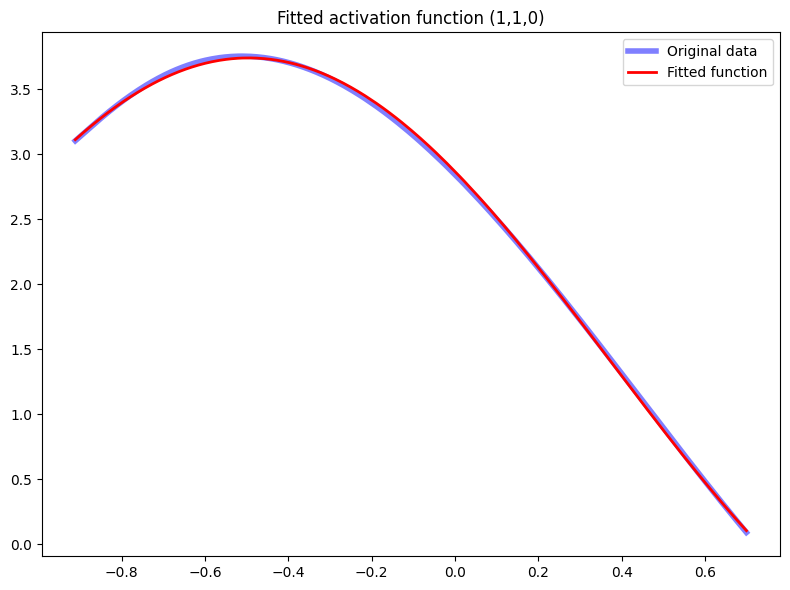

2025-03-13 05:41:53,378 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,2,0)


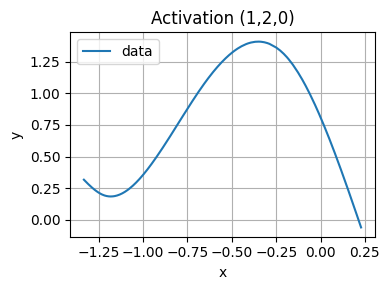

2025-03-13 05:41:53,449 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,2,0)
2025-03-13 05:41:53,451 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -4.123738765716553, for constant: [0.58882429]
2025-03-13 05:41:53,451 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:41:59,740 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:41:59,741 - LLMSR.llmSR - INFO - Initial population best: score=-0.00044433047878555954, params=[ 2.80214481  2.21944536  2.10657264  2.26602796 -1.5954236 ], ansatz: params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4]...
2025-03-13 05:41:59,741 - LLMSR.llmSR - INFO - Exit condition met after initial population
2025-03-13 05:41:59,742 - LLMSR.llmSR - INFO - Successfully found expression for connection (1,2,0)



API Call Statistics:
  Successful calls (end-to-end): 10
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 10 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 10 succeeded, 0 failed (100.00% success)
  Function Conversion: 10 succeeded, 0 failed (100.00% success)
  Curve Fitting: 10 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (1,2,0): params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4], with score -0.00044433047878555954 and parameters [ 2.802  2.219  2.107  2.266 -1.595]


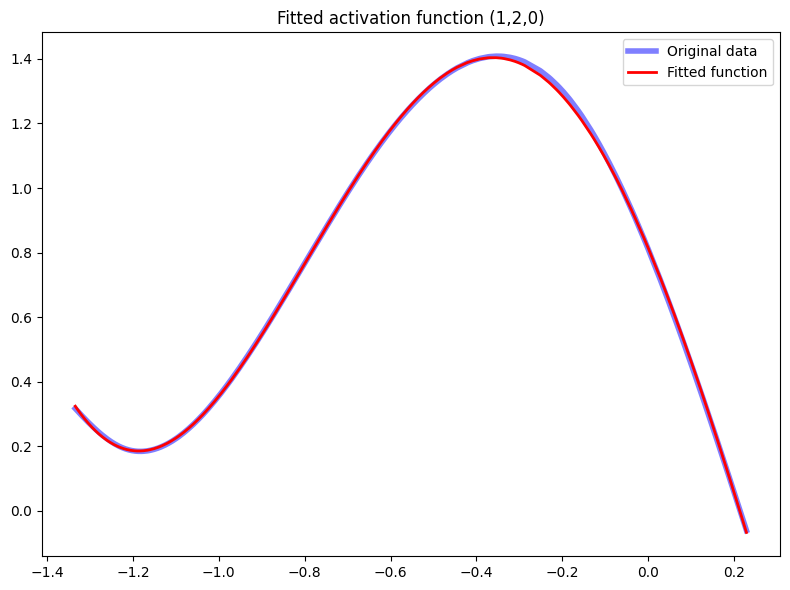

2025-03-13 05:41:59,823 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (1,3,0)


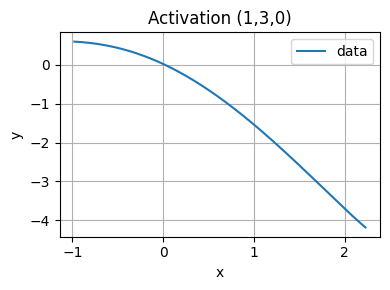

2025-03-13 05:41:59,884 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (1,3,0)
2025-03-13 05:41:59,885 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.5234302282333374, for constant: [-1.46225799]
2025-03-13 05:41:59,886 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 05:42:01,785 - LLMSR.fit - WARNING - curve fitting: invalid value encountered in log
2025-03-13 05:42:02,424 - LLMSR.llmSR - INFO - Generated 10 individuals
2025-03-13 05:42:02,425 - LLMSR.llmSR - INFO - Initial population best: score=-0.0016601759707555175, params=[-0.35521912 -1.11234381 -0.04704507], ansatz: params[0] * x**2 + params[1] * x + params[2]...
2025-03-13 05:42:02,427 - LLMSR.llmSR - INFO - Generation 1/2: Generating 10 new individuals. Async? True, elitism? False
2025-03-13 05:42:03,788 - LLMSR.fit - WARNING - curve fitting: invalid value encountered in log
2025-03-13 05:42:03,790 - LLMSR.fit - WARNING - curve fitting: invalid value encou


API Call Statistics:
  Successful calls (end-to-end): 20
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 20 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 20 succeeded, 0 failed (100.00% success)
  Function Conversion: 20 succeeded, 0 failed (100.00% success)
  Curve Fitting: 20 succeeded, 0 failed (100.00% success)

Error types:
  No errors

Validation issues:
  - nan values: 4

Fitting warnings:
  - covariance estimation: 4
  - invalid log: 61
Approximation for (1,3,0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3, with score -9.885092003969476e-05 and parameters [ 0.027 -1.129 -0.522  0.078]


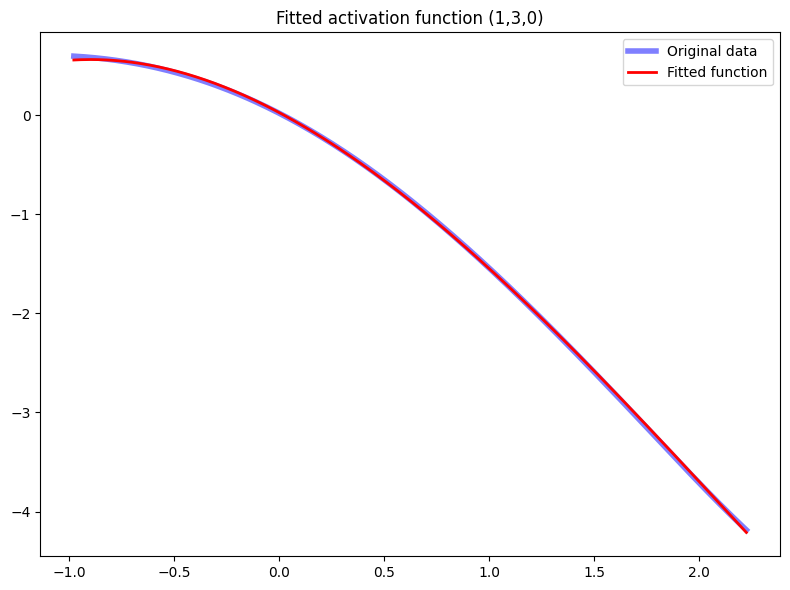

2025-03-13 05:42:07,638 - LLMSR.llmSR - INFO - KAN conversion complete: 8 total connections
2025-03-13 05:42:07,639 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 8 processed
2025-03-13 05:42:07,769 - LLMSR.llm - INFO - API key usage check successful. Current usage: 52.611698246
2025-03-13 05:42:07,769 - LLMSR.llmSR - INFO - API key usage whilst this kan_to_symbolic was running: $0.27
2025-03-13 05:42:07,770 - LLMSR.kansr - INFO - Approximation for (0, 0, 0): params[0] * np.cos(params[1] * x + params[2]) + params[3], has parameters [ 1.3  0.6  0.5 -0.7]
2025-03-13 05:42:07,771 - LLMSR.kansr - INFO - Approximation for (0, 0, 1): params[0] * np.sin(params[1] * x + params[2]) + params[3] * x**2 + params[4], has parameters [ 1.5  0.9  5.2 -0.2  0.5]
2025-03-13 05:42:07,771 - LLMSR.kansr - INFO - Approximation for (0, 0, 2): params[0] * np.sin(params[1] * x + params[2]) + params[3], has parameters [-0.9  0.7  2.  -0.4]
2025-03-13 05:42:07,772 - LLMSR.kansr - INFO - Approxi

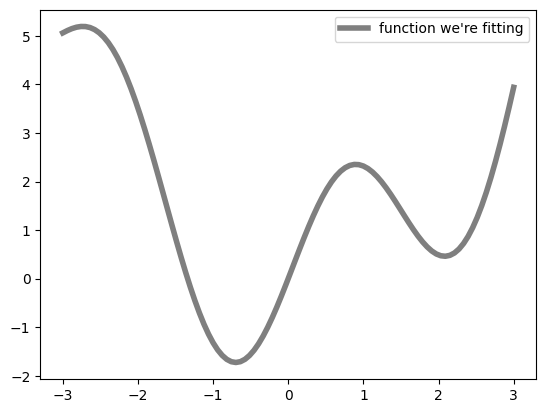

2025-03-13 05:48:54,263 - LLMSR.kansr - INFO - 
###############################
# Final formula for output 0: #
###############################
2025-03-13 05:48:54,263 - LLMSR.kansr - INFO - Best expression n_chi2 1.572e-13 from LLMsimplified fit: 0.499999910593033*x0**2 + 1.99999976158142*sin(2.0*x0)
2025-03-13 05:48:54,264 - LLMSR.kansr - INFO - Round to 4sf: 0.5*x0**2 + 2*sin(2*x0)
2025-03-13 05:48:54,587 - LLMSR.llm - INFO - API key usage check successful. Current usage: 52.650485746
2025-03-13 05:48:54,587 - LLMSR.kansr - INFO - API key usage whilst this get_symbolic was running: $0.30
2025-03-13 05:48:54,588 - LLMSR.kansr - INFO - Best expression: 0.499999910593033*x0**2 + 1.99999976158142*np.sin(2.0*x0), with n_chi2 1.5722625566934323e-13
2025-03-13 05:48:54,588 - LLMSR.kansr - INFO - Initially: 0.344201394678014*x0**2 + 0.106808661491236*x0 + 1.76148385956776*(-np.sin(0.736116895195633*x0 + 1.97033042931702) - 0.465958336883441)**2 + 0.407822651222512*(-0.175970963712625*x0**2 

In [14]:
from LLMSR.kansr import run_complete_pipeline

# Run the complete pipeline using the standalone function
results_standalone = run_complete_pipeline(
    client=client,
    f=target_function,
    ranges=(-3, 3),
    width=[1, 4, 1],
    grid=5,
    k=3,
    train_steps=50,
    generations=3,
    gpt_model="openai/gpt-4o",
    device='cpu',
    node_th=0.2,
    edge_th=0.2,
    optimiser="LBFGS",
    population=10,
    temperature=0.1,
    verbose=1,
    use_async=True,
    plot_fit=True,
    seed=42,
    simplification_gpt_model='openai/o3-mini'
)

In [16]:
# Print the best expression from the standalone pipeline
print(f"Best expression from standalone pipeline: {results_standalone['best_expressions'][0]}")
print(f"Chi-squared: {results_standalone['best_n_chi_squareds'][0]}")

Best expression from standalone pipeline: 0.499999910593033*x0**2 + 1.99999976158142*np.sin(2.0*x0)
Chi-squared: 1.5722625566934323e-13


## Advanced Example: Multi-variate Function

The KANSR class can also handle multivariate functions.

In [5]:
# Define a multivariate function
def multivariate_function(x):
    """
    Function with two input variables: f(x0, x1) = sin(x0) + 0.5 * x1^2
    
    Args:
        x: Tensor of shape [n, 2] where n is batch size
        
    Returns:
        Tensor of shape [n] with function values
    """
    if isinstance(x, torch.Tensor):
        return torch.exp(torch.sin(torch.pi * x[:, 0]) + 0.5 * x[:, 1]**2)
    else:
        return np.exp(np.sin(np.pi * x[:, 0]) + 0.5 * x[:, 1]**2)

In [6]:
# Initialize a KANSR instance for the multivariate function
multivariate_kansr = KANSR(
    client=client,
    width=[2, 1],  # 2 inputs, 5 hidden nodes, 1 output
    grid=5,
    k=3,
    seed=42
)

checkpoint directory created: ./model
saving model version 0.0


In [7]:
# Create a dataset for the multivariate function
multivariate_dataset = multivariate_kansr.create_dataset(
    f=multivariate_function,
    ranges=(-3, 3),  # Same range for both variables
    n_var=2,  # Two input variables
    train_num=10000,
    test_num=1000
)

2025-03-13 18:19:32,831 - LLMSR.kansr - INFO - Training KAN model with LBFGS optimiser for 50 steps
| train_loss: 1.55e+01 | test_loss: 1.52e+01 | reg: 1.99e+01 | : 100%|█| 50/50 [00:02<00:00, 17.90it
2025-03-13 18:19:35,727 - LLMSR.kansr - INFO - Pruning model with node_th=0.2, edge_th=0.2
2025-03-13 18:19:35,735 - LLMSR.kansr - INFO - Pruned model:
2025-03-13 18:19:35,822 - LLMSR.kansr - INFO - Final train loss: 15.525487899780273


saving model version 0.1
Unpruned model. Pruning? True
saving model version 0.2


15.525487899780273

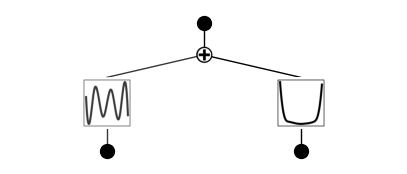

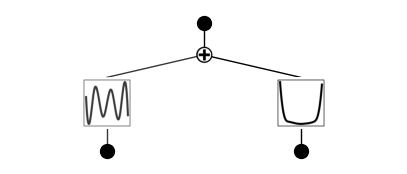

In [8]:
# Train the KAN model
multivariate_kansr.train_kan(
    dataset=multivariate_dataset,
    opt="LBFGS",
    steps=50,  # More steps for multivariate function
    prune=True,
    node_th=0.2,
    edge_th=0.2
)

2025-03-13 18:19:36,117 - LLMSR.llm - INFO - API key usage check successful. Current usage: 54.822585946
2025-03-13 18:19:36,118 - LLMSR.kansr - WARNING - Using default exit condition of 0.001. Consider passing 'overall_nchi_squared'as an exit condition - this is the n_chi_squared of the entire model on its inputs. It's not the default as this is not necessarily meaningful for each individual activation function.
2025-03-13 18:19:36,118 - LLMSR.kansr - INFO - Converting KAN model to symbolic expressions (exit_condition=0.001)
2025-03-13 18:19:36,252 - LLMSR.llm - INFO - API key usage check successful. Current usage: 54.822585946
2025-03-13 18:19:36,253 - LLMSR.llmSR - INFO - Processing KAN model connections
2025-03-13 18:19:36,254 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,0,0)


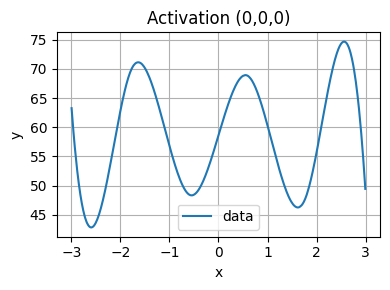

2025-03-13 18:19:36,465 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,0,0)
2025-03-13 18:19:36,903 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -1.1931297779083252, for constant: [58.53675286]
2025-03-13 18:19:36,904 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 18:19:38,873 - LLMSR.llmSR - INFO - Generated 3 individuals
2025-03-13 18:19:38,874 - LLMSR.llmSR - INFO - Initial population best: score=-1.08097505569458, params=[58.45404019 -3.92442637 -1.60488923  3.04385555], ansatz: params[0] + params[1] * np.sin(params[2] * x + params[3])...


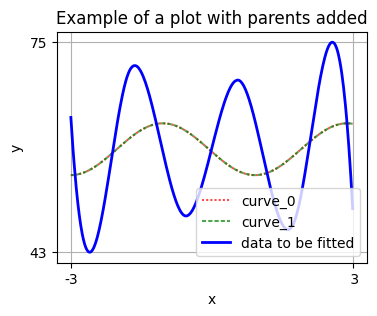

2025-03-13 18:19:38,933 - LLMSR.llmSR - INFO - Generation 1/1: Generating 3 new individuals. Async? True, elitism? False
2025-03-13 18:19:41,581 - LLMSR.llmSR - INFO - Generation 1 best: score=-0.06567708402872086, params=[ 58.55051647   0.46644698 -14.46272116   3.31371073  12.45381624
  -3.06635026  -4.75196188], ansatz: params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + param...
2025-03-13 18:19:41,582 - LLMSR.llmSR - INFO - Genetic algorithm completed after 2 generations
2025-03-13 18:19:41,582 - LLMSR.llmSR - INFO - Successfully found expression for connection (0,0,0)



API Call Statistics:
  Successful calls (end-to-end): 6
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 6 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 6 succeeded, 0 failed (100.00% success)
  Function Conversion: 6 succeeded, 0 failed (100.00% success)
  Curve Fitting: 6 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,0,0): params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + params[6]), with score -0.06567708402872086 and parameters [ 58.551   0.466 -14.463   3.314  12.454  -3.066  -4.752]


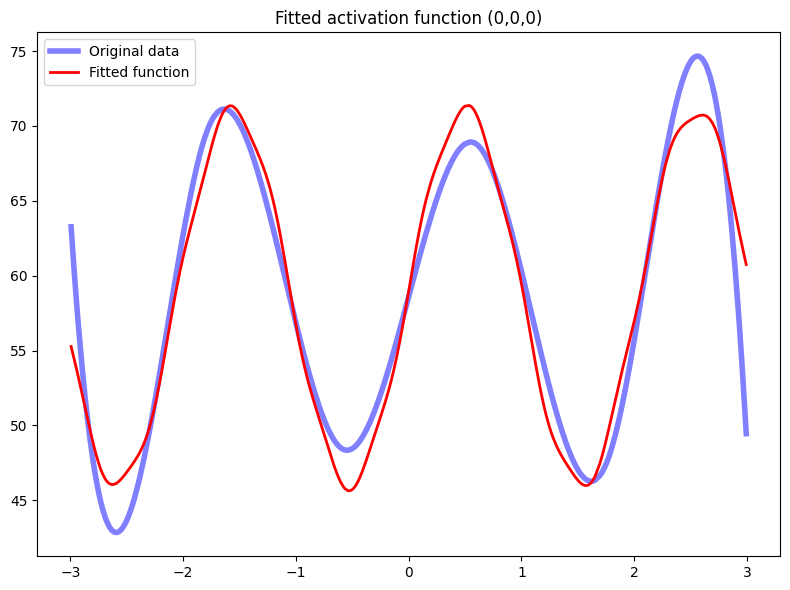

2025-03-13 18:19:41,661 - LLMSR.llmSR - INFO - Processing non-symbolic activation function (0,1,0)


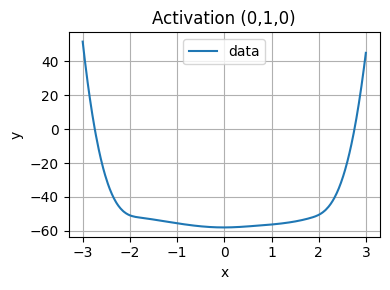

2025-03-13 18:19:41,739 - LLMSR.llmSR - INFO - Running genetic algorithm for connection (0,1,0)
2025-03-13 18:19:41,741 - LLMSR.llmSR - INFO - Constant function is not a good fit: Score: -47.40208053588867, for constant: [-42.77408483]
2025-03-13 18:19:41,742 - LLMSR.llmSR - INFO - Generating initial population asynchronously
2025-03-13 18:19:43,922 - LLMSR.llmSR - INFO - Generated 3 individuals
2025-03-13 18:19:43,922 - LLMSR.llmSR - INFO - Initial population best: score=-1.3851886987686157, params=[  1.86164159  -6.74710246 -53.38183445], ansatz: params[0] * x**4 + params[1] * x**2 + params[2]...


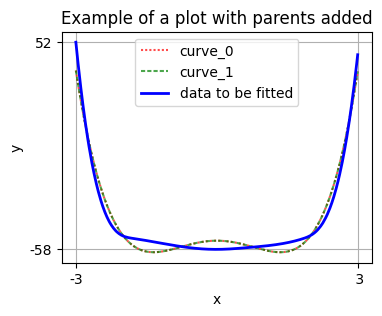

2025-03-13 18:19:43,975 - LLMSR.llmSR - INFO - Generation 1/1: Generating 3 new individuals. Async? True, elitism? False
2025-03-13 18:19:46,275 - LLMSR.llmSR - INFO - Generation 1 best: score=-11.931292533874512, params=[ -1.95324536  26.67629179   7.87404371 -66.9794427 ], ansatz: params[0] * np.cos(params[1] * x) + params[2] * x**2 + params[3]...
2025-03-13 18:19:46,275 - LLMSR.llmSR - INFO - Genetic algorithm completed after 2 generations
2025-03-13 18:19:46,276 - LLMSR.llmSR - INFO - Successfully found expression for connection (0,1,0)



API Call Statistics:
  Successful calls (end-to-end): 6
  Failed calls: 0
  Success rate: 100.00%

Breakdown by processing stage:
  Api Call: 6 succeeded, 0 failed (100.00% success)
  Ansatz Extraction: 6 succeeded, 0 failed (100.00% success)
  Function Conversion: 6 succeeded, 0 failed (100.00% success)
  Curve Fitting: 6 succeeded, 0 failed (100.00% success)

Error types:
  No errors
Approximation for (0,1,0): params[0] * x**4 + params[1] * x**2 + params[2], with score -1.3851886987686157 and parameters [  1.862  -6.747 -53.382]


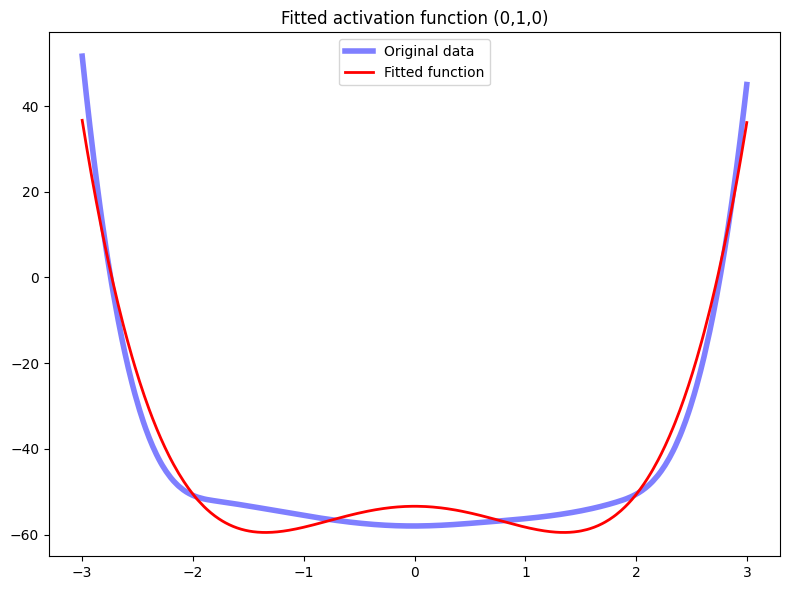

2025-03-13 18:19:46,355 - LLMSR.llmSR - INFO - KAN conversion complete: 2 total connections
2025-03-13 18:19:46,355 - LLMSR.llmSR - INFO - Connection breakdown: 0 symbolic, 0 zero, 2 processed
2025-03-13 18:19:46,496 - LLMSR.llm - INFO - API key usage check successful. Current usage: 54.822585946
2025-03-13 18:19:46,497 - LLMSR.llmSR - INFO - API key usage whilst this kan_to_symbolic was running: $0.00
2025-03-13 18:19:46,497 - LLMSR.kansr - INFO - Approximation for (0, 0, 0): params[0] + params[1] * np.sin(params[2] * x + params[3]) + params[4] * np.cos(params[5] * x + params[6]), has parameters [ 58.6   0.5 -14.5   3.3  12.5  -3.1  -4.8]
2025-03-13 18:19:46,497 - LLMSR.kansr - INFO - Approximation for (0, 1, 0): params[0] * x**4 + params[1] * x**2 + params[2], has parameters [  1.9  -6.7 -53.4]
2025-03-13 18:19:46,498 - LLMSR.kansr - INFO - Building expression tree
2025-03-13 18:19:46,498 - LLMSR.kansr - INFO - KAN Connection: (0, 0, 0), Best Expression: 58.5505164665289470 + 0.46644

In [9]:
# Convert to symbolic expressions
best_expressions, best_chi_squareds, results_dicts, results_all_dicts = multivariate_kansr.get_symbolic(
    client=client,
    population=3,
    generations=2,
    temperature=0.1,
    gpt_model="openai/gpt-4o",
    verbose=1,
    use_async=True,
    plot_fit=True,
    plot_parents=True,
    demonstrate_parent_plotting=True
)

In [ ]:
multivariate_kansr.plot_results()

Mean Squared Error with symbolic expression: 252.544601
Symbolic expression: 1.80253849718307*x1**4 - 6.34109862504698*x1**2 + 13.2176750604826*np.cos(3.14188320690847*x0 + 4.73783449684339) + 4.84271539366691


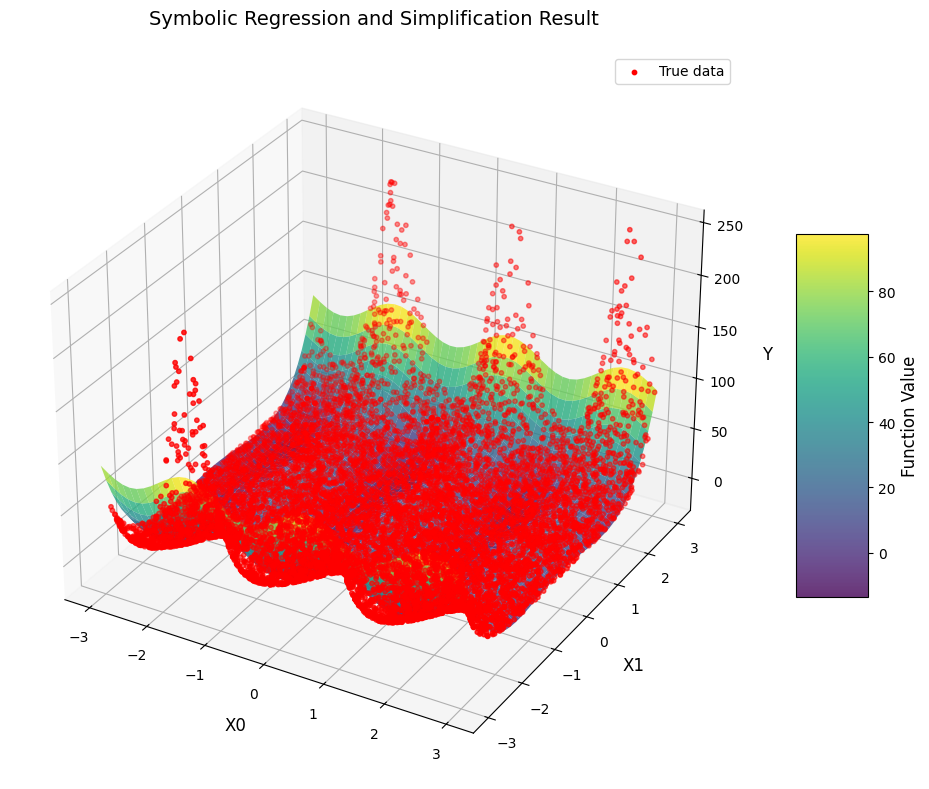

In [ ]:
from LLMSR.images import plot_3d_function
dataset = multivariate_kansr.dataset
# Create a grid of input points
extractrange = 'train_input'
plot_type = 'train_input','train_label'
x0_range = np.linspace(min(dataset[plot_type[0]][:,0]), max(dataset[plot_type[0]][:,0]), 50)
x1_range = np.linspace(min(dataset[plot_type[0]][:,1]), max(dataset[plot_type[0]][:,1]), 50)
X0, X1 = np.meshgrid(x0_range, x1_range)

# Extract test data
test_x0 = dataset[plot_type[0]][:,0].cpu().detach().numpy()
test_x1 = dataset[plot_type[0]][:,1].cpu().detach().numpy()
test_y = dataset[plot_type[1]].cpu().detach().numpy().flatten()
test_data = (test_x0, test_x1, test_y)

# # Create figure with two subplots
# fig = plt.figure(figsize=(12, 8))
# ax1 = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122, projection='3d')



# Plot symbolic regression result if available
if best_expressions[0] is not None:
    # Create a symbolic function from the best expression
    symbolic_func = eval('lambda x0,x1:' + best_expressions[0])
    
    # Compute function values with symbolic expression
    Z_symbolic = np.zeros(X0.shape)
    for i in range(len(x0_range)):
        for j in range(len(x1_range)):
            try:
                Z_symbolic[j, i] = symbolic_func(X0[j, i], X1[j, i])
            except:
                Z_symbolic[j, i] = np.nan
    
    # Create new figure for symbolic result
    fig2 = plt.figure(figsize=(12, 8))
    ax3 = fig2.add_subplot(111, projection='3d')
    
    # Plot symbolic regression result
    plot_3d_function(x0_range, x1_range, Z_symbolic, test_data, 
                    'Symbolic Regression and Simplification Result', 'viridis', ax3)
    
    # Calculate MSE for symbolic expression
    y_pred_symbolic = np.array([symbolic_func(x0, x1) for x0, x1 in zip(test_x0, test_x1)])
    mse_symbolic = np.mean((y_pred_symbolic - test_y)**2)
    
    print(f"Mean Squared Error with symbolic expression: {mse_symbolic:.6f}")
    print(f"Symbolic expression: {best_expressions[0]}")

plt.tight_layout()
plt.show()


In [15]:
# Print the best expression
print(f"Best multivariate expression: {best_expressions[0]}")
print(f"Chi-squared: {best_chi_squareds[0]}")

Best multivariate expression: 1.80253849718307*x1**4 - 6.34109862504698*x1**2 + 13.2176750604826*np.cos(3.14188320690847*x0 + 4.73783449684339) + 4.84271539366691
Chi-squared: 35.14888000488281


# Here's some code explaining how the n_chi-squared works, and demonstrating what it's sensitive to:

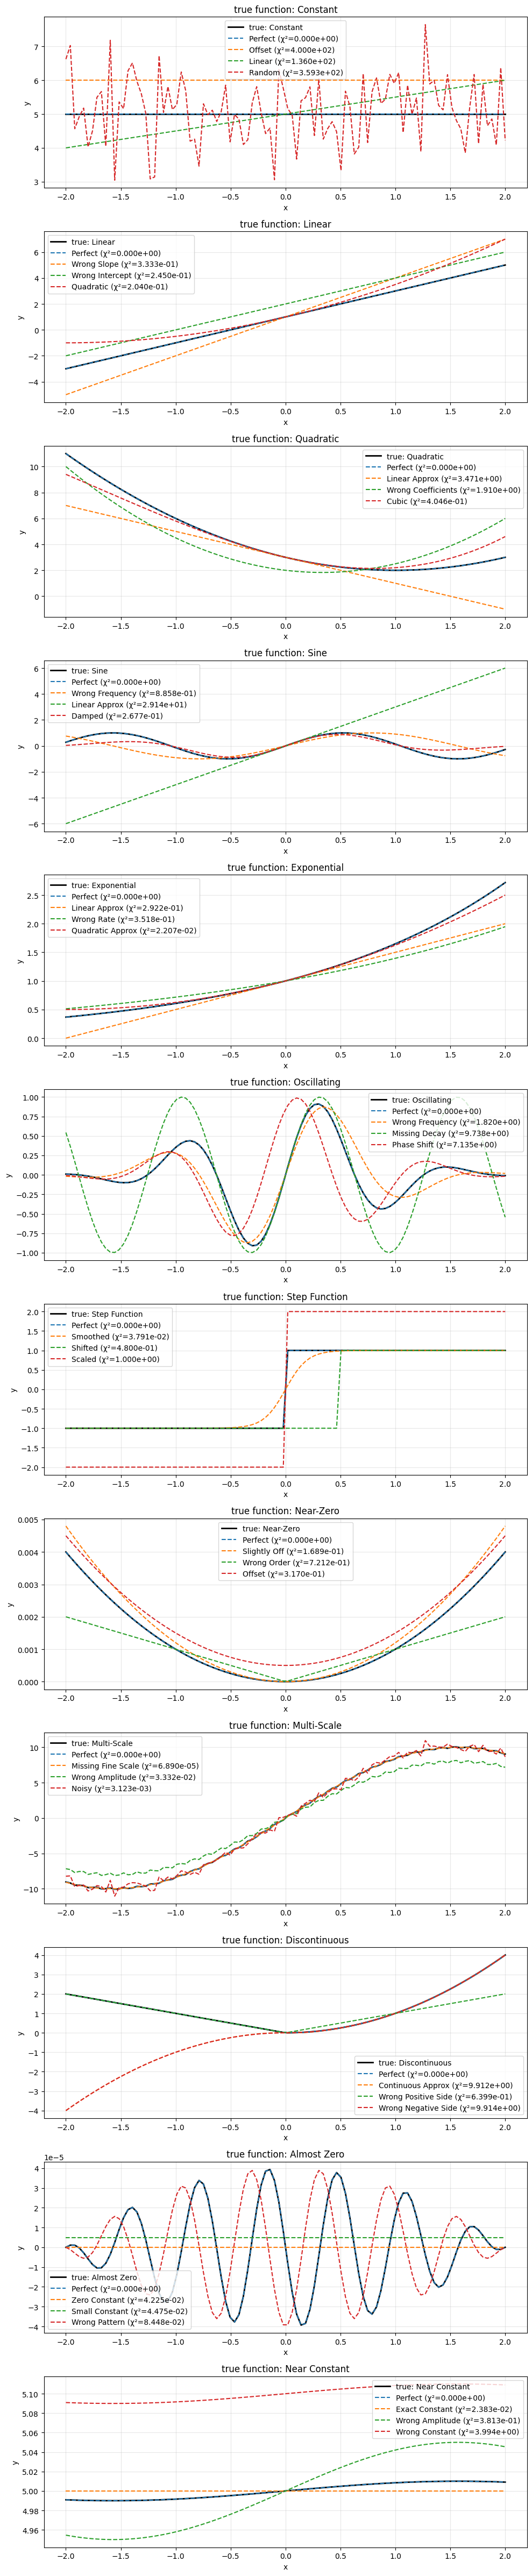

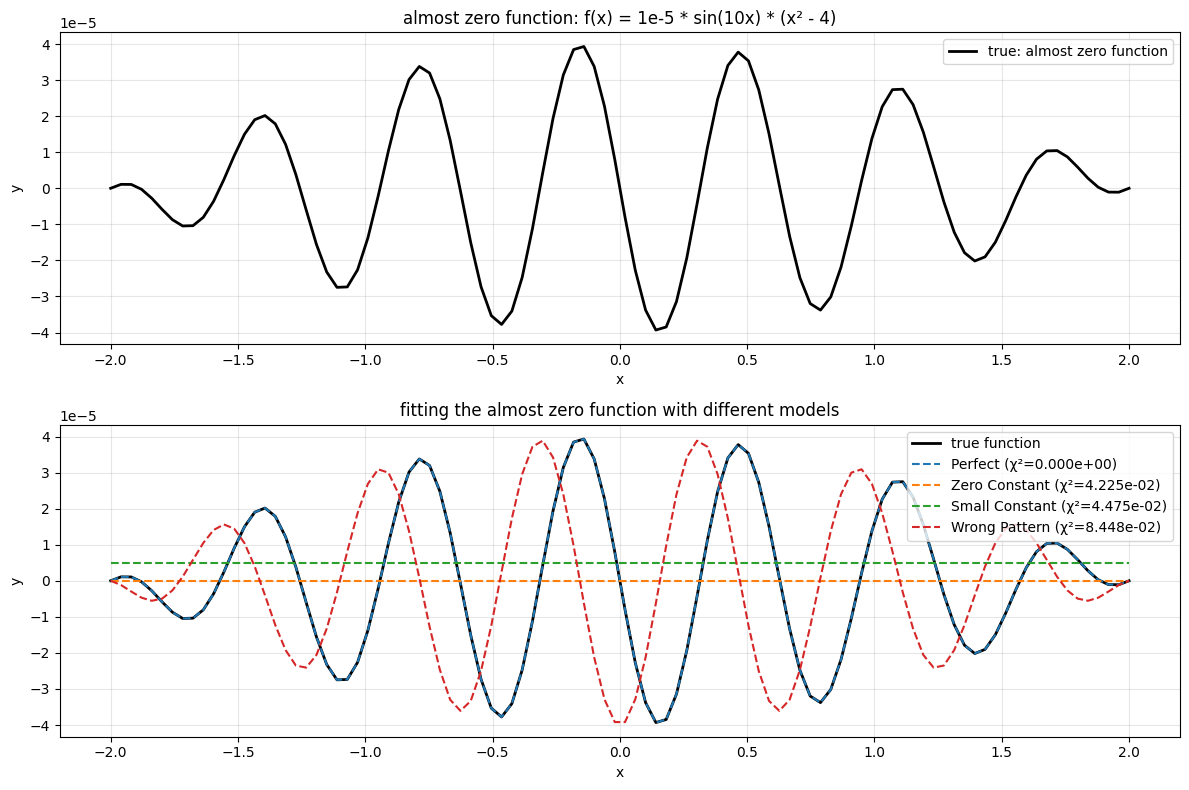

summary of normalized chi-squared values:
------------------------------------------------------------
true function   | prediction      | χ²        
------------------------------------------------------------
Constant        | Perfect         | 0.000e+00 
Constant        | Offset          | 4.000e+02 
Constant        | Linear          | 1.360e+02 
Constant        | Random          | 3.593e+02 
Linear          | Perfect         | 0.000e+00 
Linear          | Wrong Slope     | 3.333e-01 
Linear          | Wrong Intercept | 2.450e-01 
Linear          | Quadratic       | 2.040e-01 
Quadratic       | Perfect         | 0.000e+00 
Quadratic       | Linear Approx   | 3.471e+00 
Quadratic       | Wrong Coefficients | 1.910e+00 
Quadratic       | Cubic           | 4.046e-01 
Sine            | Perfect         | 0.000e+00 
Sine            | Wrong Frequency | 8.858e-01 
Sine            | Linear Approx   | 2.914e+01 
Sine            | Damped          | 2.677e-01 
Exponential     | Perfect         

In [ ]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpy as np

def get_n_chi_squared_from_predictions(x, y, predictions, alpha=0.01, eps_scale=1e-4):
    """
    Calculate a robust, scale-invariant "normalized chi-squared" from actual values and predictions.

    Args:
        x: Input data points (not used, kept for API consistency)
        y: Actual target values (1D array)
        predictions: Predicted values (1D array)
        alpha: Small fraction for relative scale (default 0.01)
        eps_scale: Absolute floor to avoid zero in scale (default 1e-8)

    Returns:
        float: Robust normalized chi-squared value
    """

    # Residuals
    residuals = y - predictions

    # A simple, robust scale measure: median absolute deviation
    median_y = jnp.median(y)
    mad_y = jnp.median(jnp.abs(y - median_y))

    # Mean of y (for additional scale-based floor)
    mean_y = jnp.mean(jnp.abs(y))

    # Define a robust overall scale, ensuring it never collapses to zero
    # (ties scale to MAD and a fraction of the mean magnitude)
    robust_scale = jnp.maximum(mad_y, alpha * mean_y)
    robust_scale = jnp.maximum(robust_scale, eps_scale)

    # For each data point, define a local denominator to smoothly handle
    # relative vs. absolute error. This prevents blow-up near zero.
    # delta_i = max(robust_scale, alpha * |y_i|)
    abs_y = jnp.abs(y)
    local_scale = jnp.maximum(robust_scale, alpha * abs_y)

    # Compute normalized chi-squared
    # (residual^2 / local_scale^2), then average
    n_chi_squared = jnp.mean((residuals ** 2) / (local_scale ** 2))

    return float(n_chi_squared)

# Test the function on various true functions and predictions
x = jnp.linspace(-2, 2, 100)  # Domain [-2, 2]

# Define several true functions
true_functions = {
    "Constant": lambda x: jnp.ones_like(x) * 5,
    "Linear": lambda x: 2*x + 1,
    "Quadratic": lambda x: x**2 - 2*x + 3,
    "Sine": lambda x: jnp.sin(3*x),
    "Exponential": lambda x: jnp.exp(x/2),
    # Additional challenging functions
    "Oscillating": lambda x: jnp.sin(5*x) * jnp.exp(-x**2),
    "Step Function": lambda x: jnp.where(x > 0, 1.0, -1.0),
    "Near-Zero": lambda x: 0.001 * x**2,
    "Multi-Scale": lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x),
    "Discontinuous": lambda x: jnp.where(x > 0, x**2, -x),
    # New approximately zero function
    "Almost Zero": lambda x: 1e-5 * jnp.sin(10*x) * (x**2 - 4),
    # Near constant function at approximately 5
    "Near Constant": lambda x: 5 + 0.01 * jnp.sin(x)
}

# Create a random key for jax random operations
key = jr.PRNGKey(0)

# For each true function, define several predictions with varying accuracy
predictions = {
    "Constant": [
        ("Perfect", lambda x: jnp.ones_like(x) * 5),
        ("Offset", lambda x: jnp.ones_like(x) * 6),
        ("Linear", lambda x: 0.5*x + 5),
        ("Random", lambda x: jnp.ones_like(x) * 5 + jr.normal(key, shape=x.shape))
    ],
    "Linear": [
        ("Perfect", lambda x: 2*x + 1),
        ("Wrong Slope", lambda x: 3*x + 1),
        ("Wrong Intercept", lambda x: 2*x + 2),
        ("Quadratic", lambda x: 0.5*x**2 + 2*x + 1)
    ],
    "Quadratic": [
        ("Perfect", lambda x: x**2 - 2*x + 3),
        ("Linear Approx", lambda x: -2*x + 3),
        ("Wrong Coefficients", lambda x: 1.5*x**2 - x + 2),
        ("Cubic", lambda x: 0.2*x**3 + x**2 - 2*x + 3)
    ],
    "Sine": [
        ("Perfect", lambda x: jnp.sin(3*x)),
        ("Wrong Frequency", lambda x: jnp.sin(2*x)),
        ("Linear Approx", lambda x: 3*x),
        ("Damped", lambda x: jnp.sin(3*x) * jnp.exp(-0.5*x**2))
    ],
    "Exponential": [
        ("Perfect", lambda x: jnp.exp(x/2)),
        ("Linear Approx", lambda x: 1 + x/2),
        ("Wrong Rate", lambda x: jnp.exp(x/3)),
        ("Quadratic Approx", lambda x: 1 + x/2 + x**2/8)
    ],
    # Additional challenging cases
    "Oscillating": [
        ("Perfect", lambda x: jnp.sin(5*x) * jnp.exp(-x**2)),
        ("Wrong Frequency", lambda x: jnp.sin(4*x) * jnp.exp(-x**2)),
        ("Missing Decay", lambda x: jnp.sin(5*x)),
        ("Phase Shift", lambda x: jnp.sin(5*x + 1) * jnp.exp(-x**2))
    ],
    "Step Function": [
        ("Perfect", lambda x: jnp.where(x > 0, 1.0, -1.0)),
        ("Smoothed", lambda x: jnp.tanh(5*x)),
        ("Shifted", lambda x: jnp.where(x > 0.5, 1.0, -1.0)),
        ("Scaled", lambda x: jnp.where(x > 0, 2.0, -2.0))
    ],
    "Near-Zero": [
        ("Perfect", lambda x: 0.001 * x**2),
        ("Slightly Off", lambda x: 0.0012 * x**2),
        ("Wrong Order", lambda x: 0.001 * jnp.abs(x)),
        ("Offset", lambda x: 0.001 * x**2 + 0.0005)
    ],
    "Multi-Scale": [
        ("Perfect", lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x)),
        ("Missing Fine Scale", lambda x: 10*jnp.sin(x)),
        ("Wrong Amplitude", lambda x: 8*jnp.sin(x) + 0.2*jnp.sin(50*x)),
        ("Noisy", lambda x: 10*jnp.sin(x) + 0.1*jnp.sin(50*x) + 0.5*jr.normal(key, shape=x.shape))
    ],
    "Discontinuous": [
        ("Perfect", lambda x: jnp.where(x > 0, x**2, -x)),
        ("Continuous Approx", lambda x: x**2 * jnp.tanh(5*x)),
        ("Wrong Positive Side", lambda x: jnp.where(x > 0, x, -x)),
        ("Wrong Negative Side", lambda x: jnp.where(x > 0, x**2, -x**2))
    ],
    # New predictions for the almost zero function
    "Almost Zero": [
        ("Perfect", lambda x: 1e-5 * jnp.sin(10*x) * (x**2 - 4)),
        ("Zero Constant", lambda x: jnp.zeros_like(x)),  # Constant zero
        ("Small Constant", lambda x: jnp.ones_like(x) * 5e-6),  # Small non-zero constant
        ("Wrong Pattern", lambda x: 1e-5 * jnp.cos(10*x) * (x**2 - 4))  # Wrong oscillation pattern
    ],
    # Predictions for the near constant function
    "Near Constant": [
        ("Perfect", lambda x: 5 + 0.01 * jnp.sin(x)),
        ("Exact Constant", lambda x: jnp.ones_like(x) * 5),  # Pure constant approximation
        ("Wrong Amplitude", lambda x: 5 + 0.05 * jnp.sin(x)),  # Larger oscillation
        ("Wrong Constant", lambda x: 5.1 + 0.01 * jnp.sin(x))  # Offset baseline
    ]
}

# Create plots for each true function
fig, axes = plt.subplots(len(true_functions), 1, figsize=(10, 4*len(true_functions)))

for i, (func_name, true_func) in enumerate(true_functions.items()):
    ax = axes[i]
    
    # Calculate true values
    y_true = true_func(x)
    
    # Plot true function
    ax.plot(x, y_true, 'k-', linewidth=2, label=f'true: {func_name}')
    
    # Plot and evaluate each prediction
    for pred_name, pred_func in predictions[func_name]:
        y_pred = pred_func(x)
        chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
        ax.plot(x, y_pred, '--', linewidth=1.5, label=f'{pred_name} (χ²={chi2:.3e})')
    
    ax.set_title(f'true function: {func_name}')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Special focus on the "Almost Zero" function
plt.figure(figsize=(12, 8))

# Get the true function and its predictions
almost_zero_func = true_functions["Almost Zero"]
y_true = almost_zero_func(x)

plt.subplot(2, 1, 1)
plt.plot(x, y_true, 'k-', linewidth=2, label='true: almost zero function')
plt.title('almost zero function: f(x) = 1e-5 * sin(10x) * (x² - 4)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, y_true, 'k-', linewidth=2, label='true function')

# Plot each prediction with chi-squared value
for pred_name, pred_func in predictions["Almost Zero"]:
    y_pred = pred_func(x)
    chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
    plt.plot(x, y_pred, '--', linewidth=1.5, label=f'{pred_name} (χ²={chi2:.3e})')

plt.title('fitting the almost zero function with different models')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print a summary table of chi-squared values
print("summary of normalized chi-squared values:")
print("-" * 60)
print(f"{'true function':<15} | {'prediction':<15} | {'χ²':<10}")
print("-" * 60)

for func_name, true_func in true_functions.items():
    y_true = true_func(x)
    for pred_name, pred_func in predictions[func_name]:
        y_pred = pred_func(x)
        chi2 = get_n_chi_squared_from_predictions(x, y_true, y_pred)
        print(f"{func_name:<15} | {pred_name:<15} | {chi2:<10.3e}")

# Demonstrate why this measure is superior to traditional metrics
print("\nwhy this normalized chi-squared measure is superior:")
print("-" * 60)

# Case 1: Compare with traditional MSE for different scales
print("1. scale invariance:")
large_scale_func = lambda x: 1000 * jnp.sin(x)
small_scale_func = lambda x: 0.001 * jnp.sin(x)

large_pred = lambda x: 1000 * jnp.sin(x) * 0.9  # 10% off
small_pred = lambda x: 0.001 * jnp.sin(x) * 0.9  # 10% off

large_y = large_scale_func(x)
small_y = small_scale_func(x)
large_pred_y = large_pred(x)
small_pred_y = small_pred(x)

large_mse = jnp.mean((large_y - large_pred_y)**2)
small_mse = jnp.mean((small_y - small_pred_y)**2)
large_chi2 = get_n_chi_squared_from_predictions(x, large_y, large_pred_y)
small_chi2 = get_n_chi_squared_from_predictions(x, small_y, small_pred_y)

print(f"large scale function mse: {large_mse:.3e}, chi²: {large_chi2:.3e}")
print(f"small scale function mse: {small_mse:.3e}, chi²: {small_chi2:.3e}")
print(f"mse ratio: {large_mse/small_mse:.3e}, chi² ratio: {large_chi2/small_chi2:.3e}")
print("→ our measure correctly identifies that both predictions have similar quality (10% off),")
print("  while mse is dominated by the function's scale.")

# Case 2: Handling near-zero values
print("\n2. robustness near zero:")
zero_cross_func = lambda x: x
zero_cross_pred1 = lambda x: x + 0.1  # constant offset
zero_cross_pred2 = lambda x: 1.1 * x  # proportional error

zero_y = zero_cross_func(x)
zero_pred1_y = zero_cross_pred1(x)
zero_pred2_y = zero_cross_pred2(x)

# Calculate relative error at different points
x_points = jnp.array([-1.0, -0.1, -0.01, 0.0, 0.01, 0.1, 1.0])
y_points = zero_cross_func(x_points)
pred1_points = zero_cross_pred1(x_points)
pred2_points = zero_cross_pred2(x_points)

print("relative errors at different points:")
print(f"{'x':<8} | {'y':<8} | {'pred1':<8} | {'relerr1':<8} | {'pred2':<8} | {'relerr2':<8}")
for i in range(len(x_points)):
    # Avoid division by zero
    rel_err1 = "∞" if y_points[i] == 0 else f"{abs((pred1_points[i] - y_points[i])/max(abs(y_points[i]), 1e-10)):.3f}"
    rel_err2 = "∞" if y_points[i] == 0 else f"{abs((pred2_points[i] - y_points[i])/max(abs(y_points[i]), 1e-10)):.3f}"
    print(f"{x_points[i]:<8.3f} | {y_points[i]:<8.3f} | {pred1_points[i]:<8.3f} | {rel_err1:<8} | {pred2_points[i]:<8.3f} | {rel_err2:<8}")

chi2_pred1 = get_n_chi_squared_from_predictions(x, zero_y, zero_pred1_y)
chi2_pred2 = get_n_chi_squared_from_predictions(x, zero_y, zero_pred2_y)
print(f"Constant offset Chi²: {chi2_pred1:.3e}")
print(f"Proportional error Chi²: {chi2_pred2:.3e}")
print("→ Our measure handles zero-crossings gracefully without infinite relative errors")

# Case 3: Robustness to outliers
print("\n3. Robustness to Outliers:")
base_func = lambda x: x**2
outlier_pred = lambda x: x**2 + jnp.where(jnp.abs(x) > 1.9, 10.0, 0.0)  # large error at edges
uniform_error_pred = lambda x: x**2 * 1.2  # 20% error everywhere

base_y = base_func(x)
outlier_y = outlier_pred(x)
uniform_y = uniform_error_pred(x)

mse_outlier = jnp.mean((base_y - outlier_y)**2)
mse_uniform = jnp.mean((base_y - uniform_y)**2)
chi2_outlier = get_n_chi_squared_from_predictions(x, base_y, outlier_y)
chi2_uniform = get_n_chi_squared_from_predictions(x, base_y, uniform_y)

print(f"Outlier errors MSE: {mse_outlier:.3e}, Chi²: {chi2_outlier:.3e}")
print(f"Uniform 20% error MSE: {mse_uniform:.3e}, Chi²: {chi2_uniform:.3e}")
print("→ Our measure is less sensitive to a few extreme outliers compared to MSE")
print("  while still penalizing systematic errors appropriately")

print("\nConclusion: This normalized chi-squared measure provides a robust, scale-invariant")
print("metric that works well across diverse function types, handles near-zero values")
print("gracefully, and is reasonably robust to outliers - making it ideal for symbolic")
print("regression quality assessment.")
